In [1]:
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as pg
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import namedtuple
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn import metrics
import lightgbm as lgb

pio.templates.default = "plotly_dark"

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.autolayout"] = True
sns.set_context('talk', rc={'xtick.major.size': 0.0,
                            'xtick.minor.size': 0.0,
                            'ytick.major.size': 0.0,
                            'ytick.minor.size': 0.0,
                            })
# plt.rcParams['axes.grid'] = False
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.edgecolor'] = '#cbcbcb'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False


In [2]:
df = pd.read_csv('ibm_telco_customer_churn.csv')

check_nans = df.isna().sum()
print(check_nans[check_nans!=0].to_string())

Churn Reason    5174


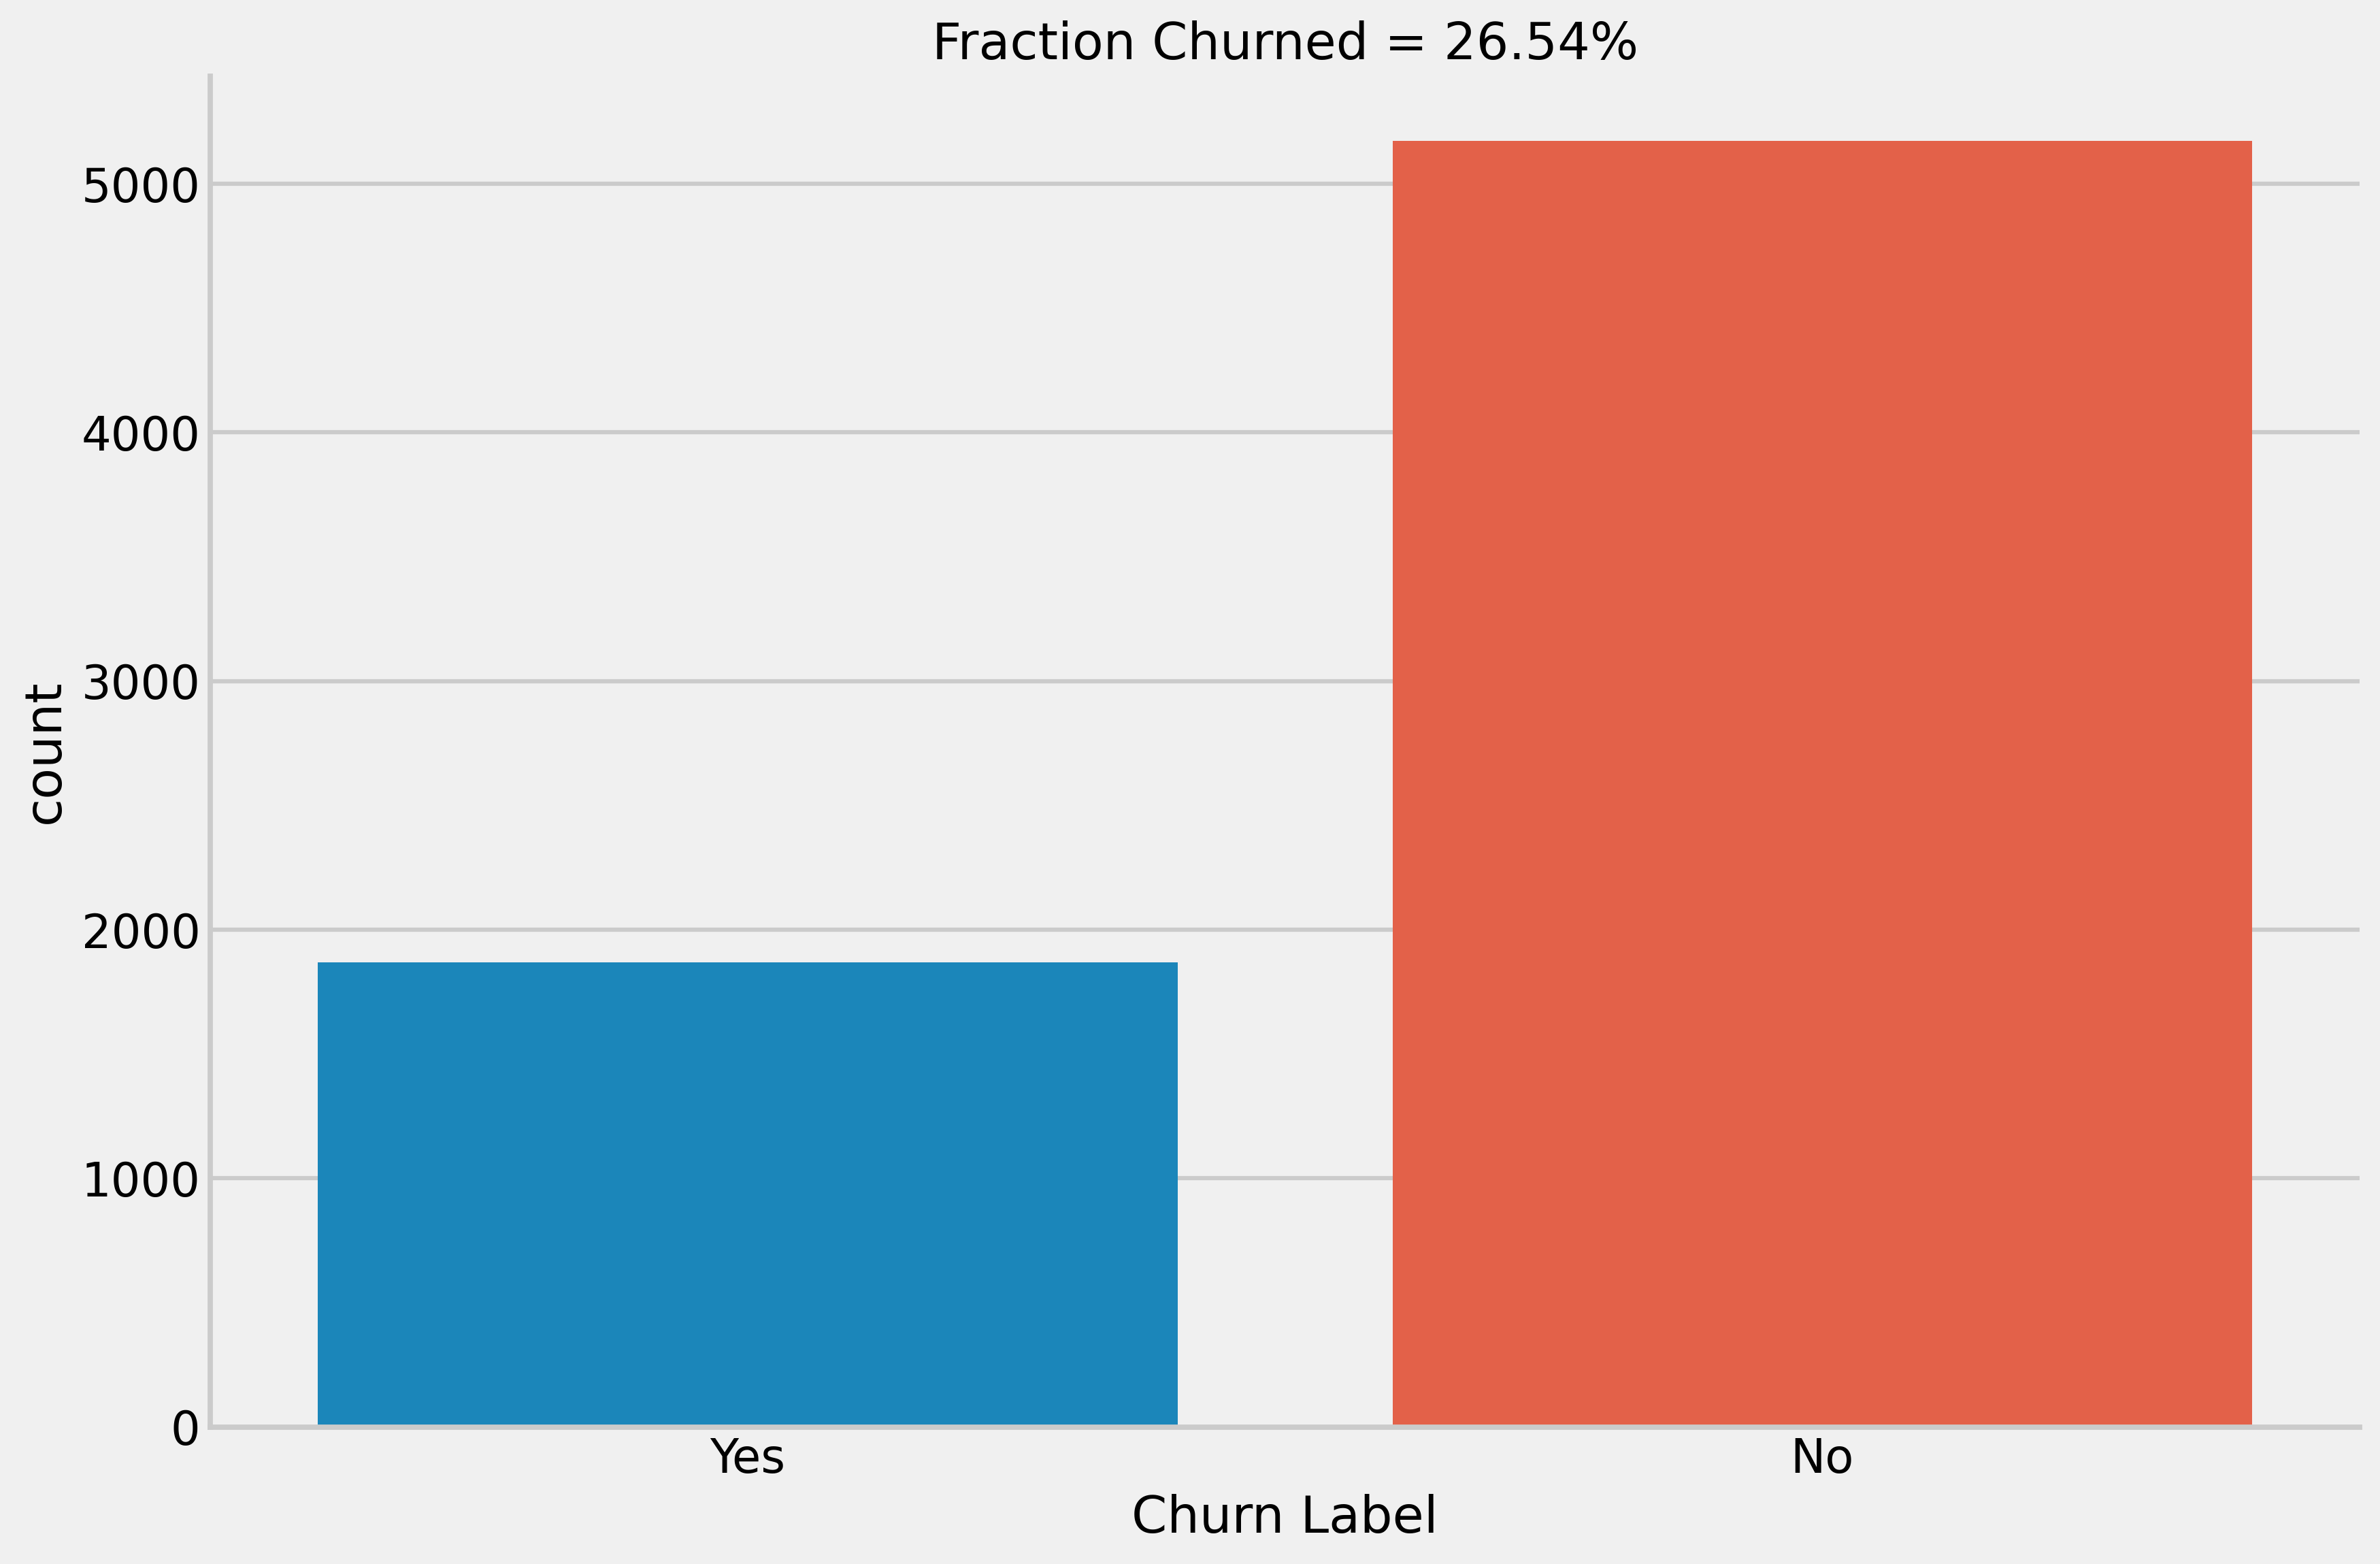

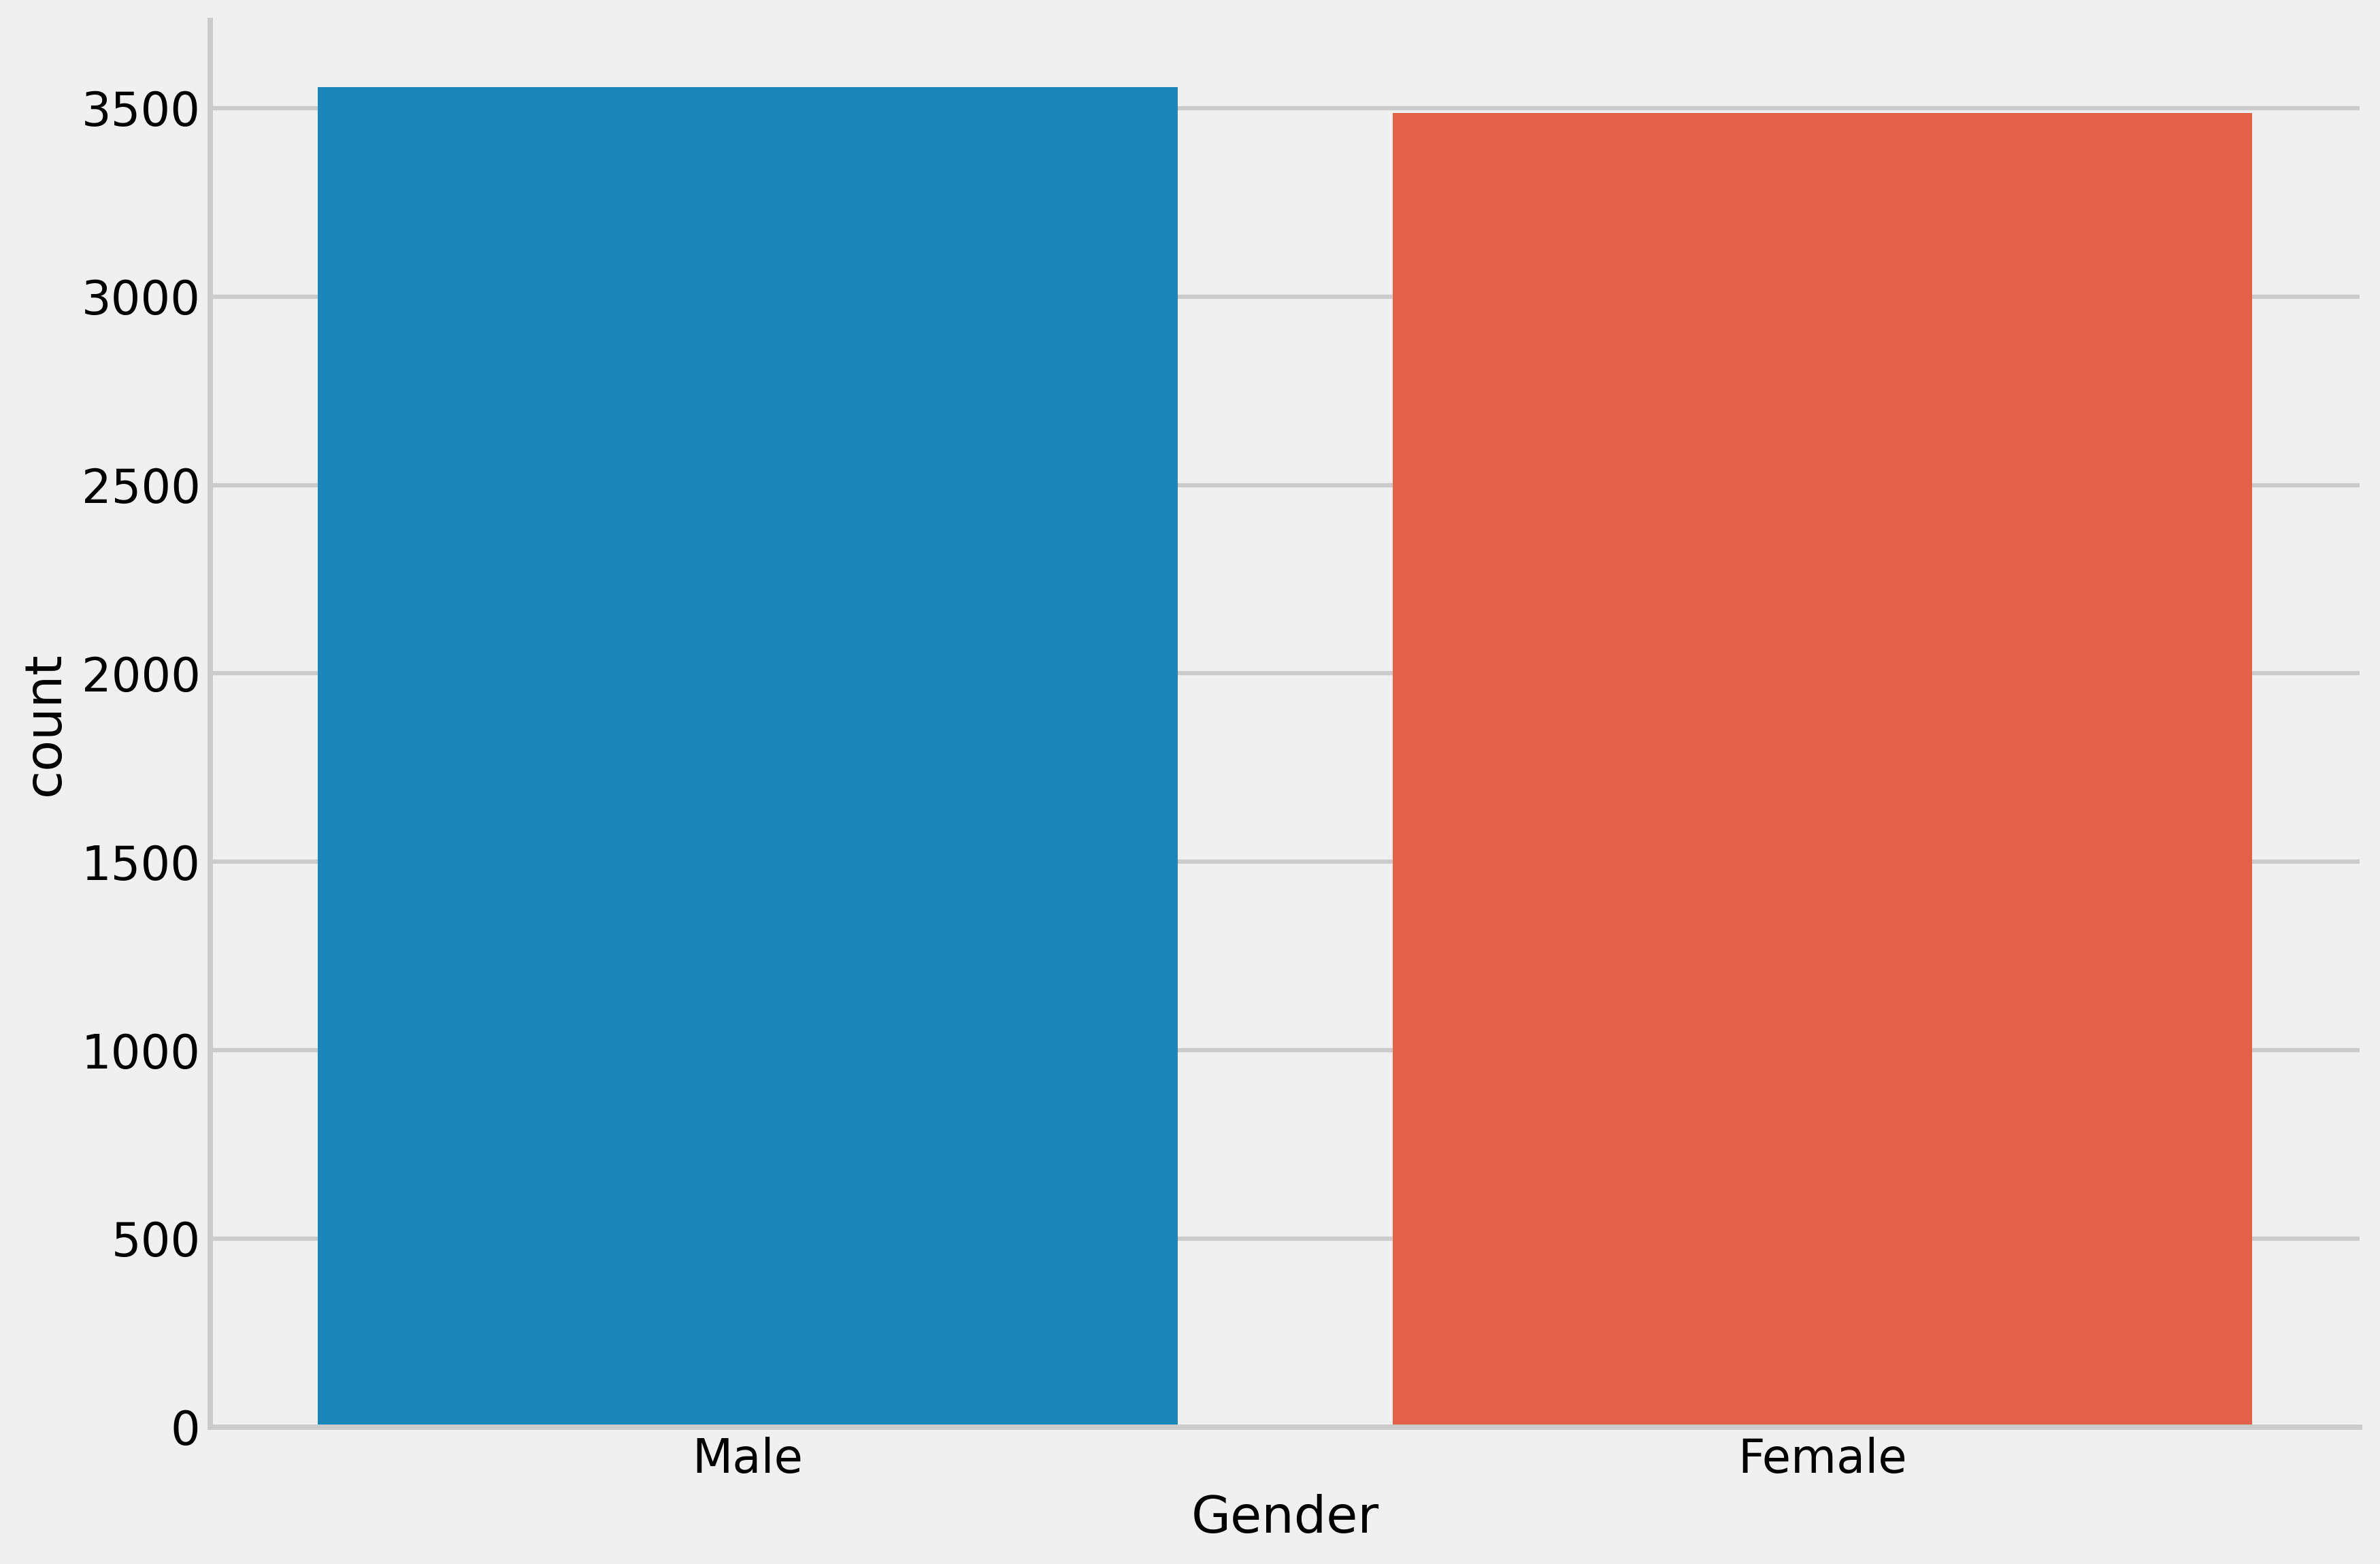

In [3]:
churn_fraction = df['Churn Value'].mean()

sns.countplot(x=df['Churn Label'])
plt.title(f'Fraction Churned = {churn_fraction*100:.2f}%',)
plt.show()

sns.countplot(x=df['Gender'])
plt.show()


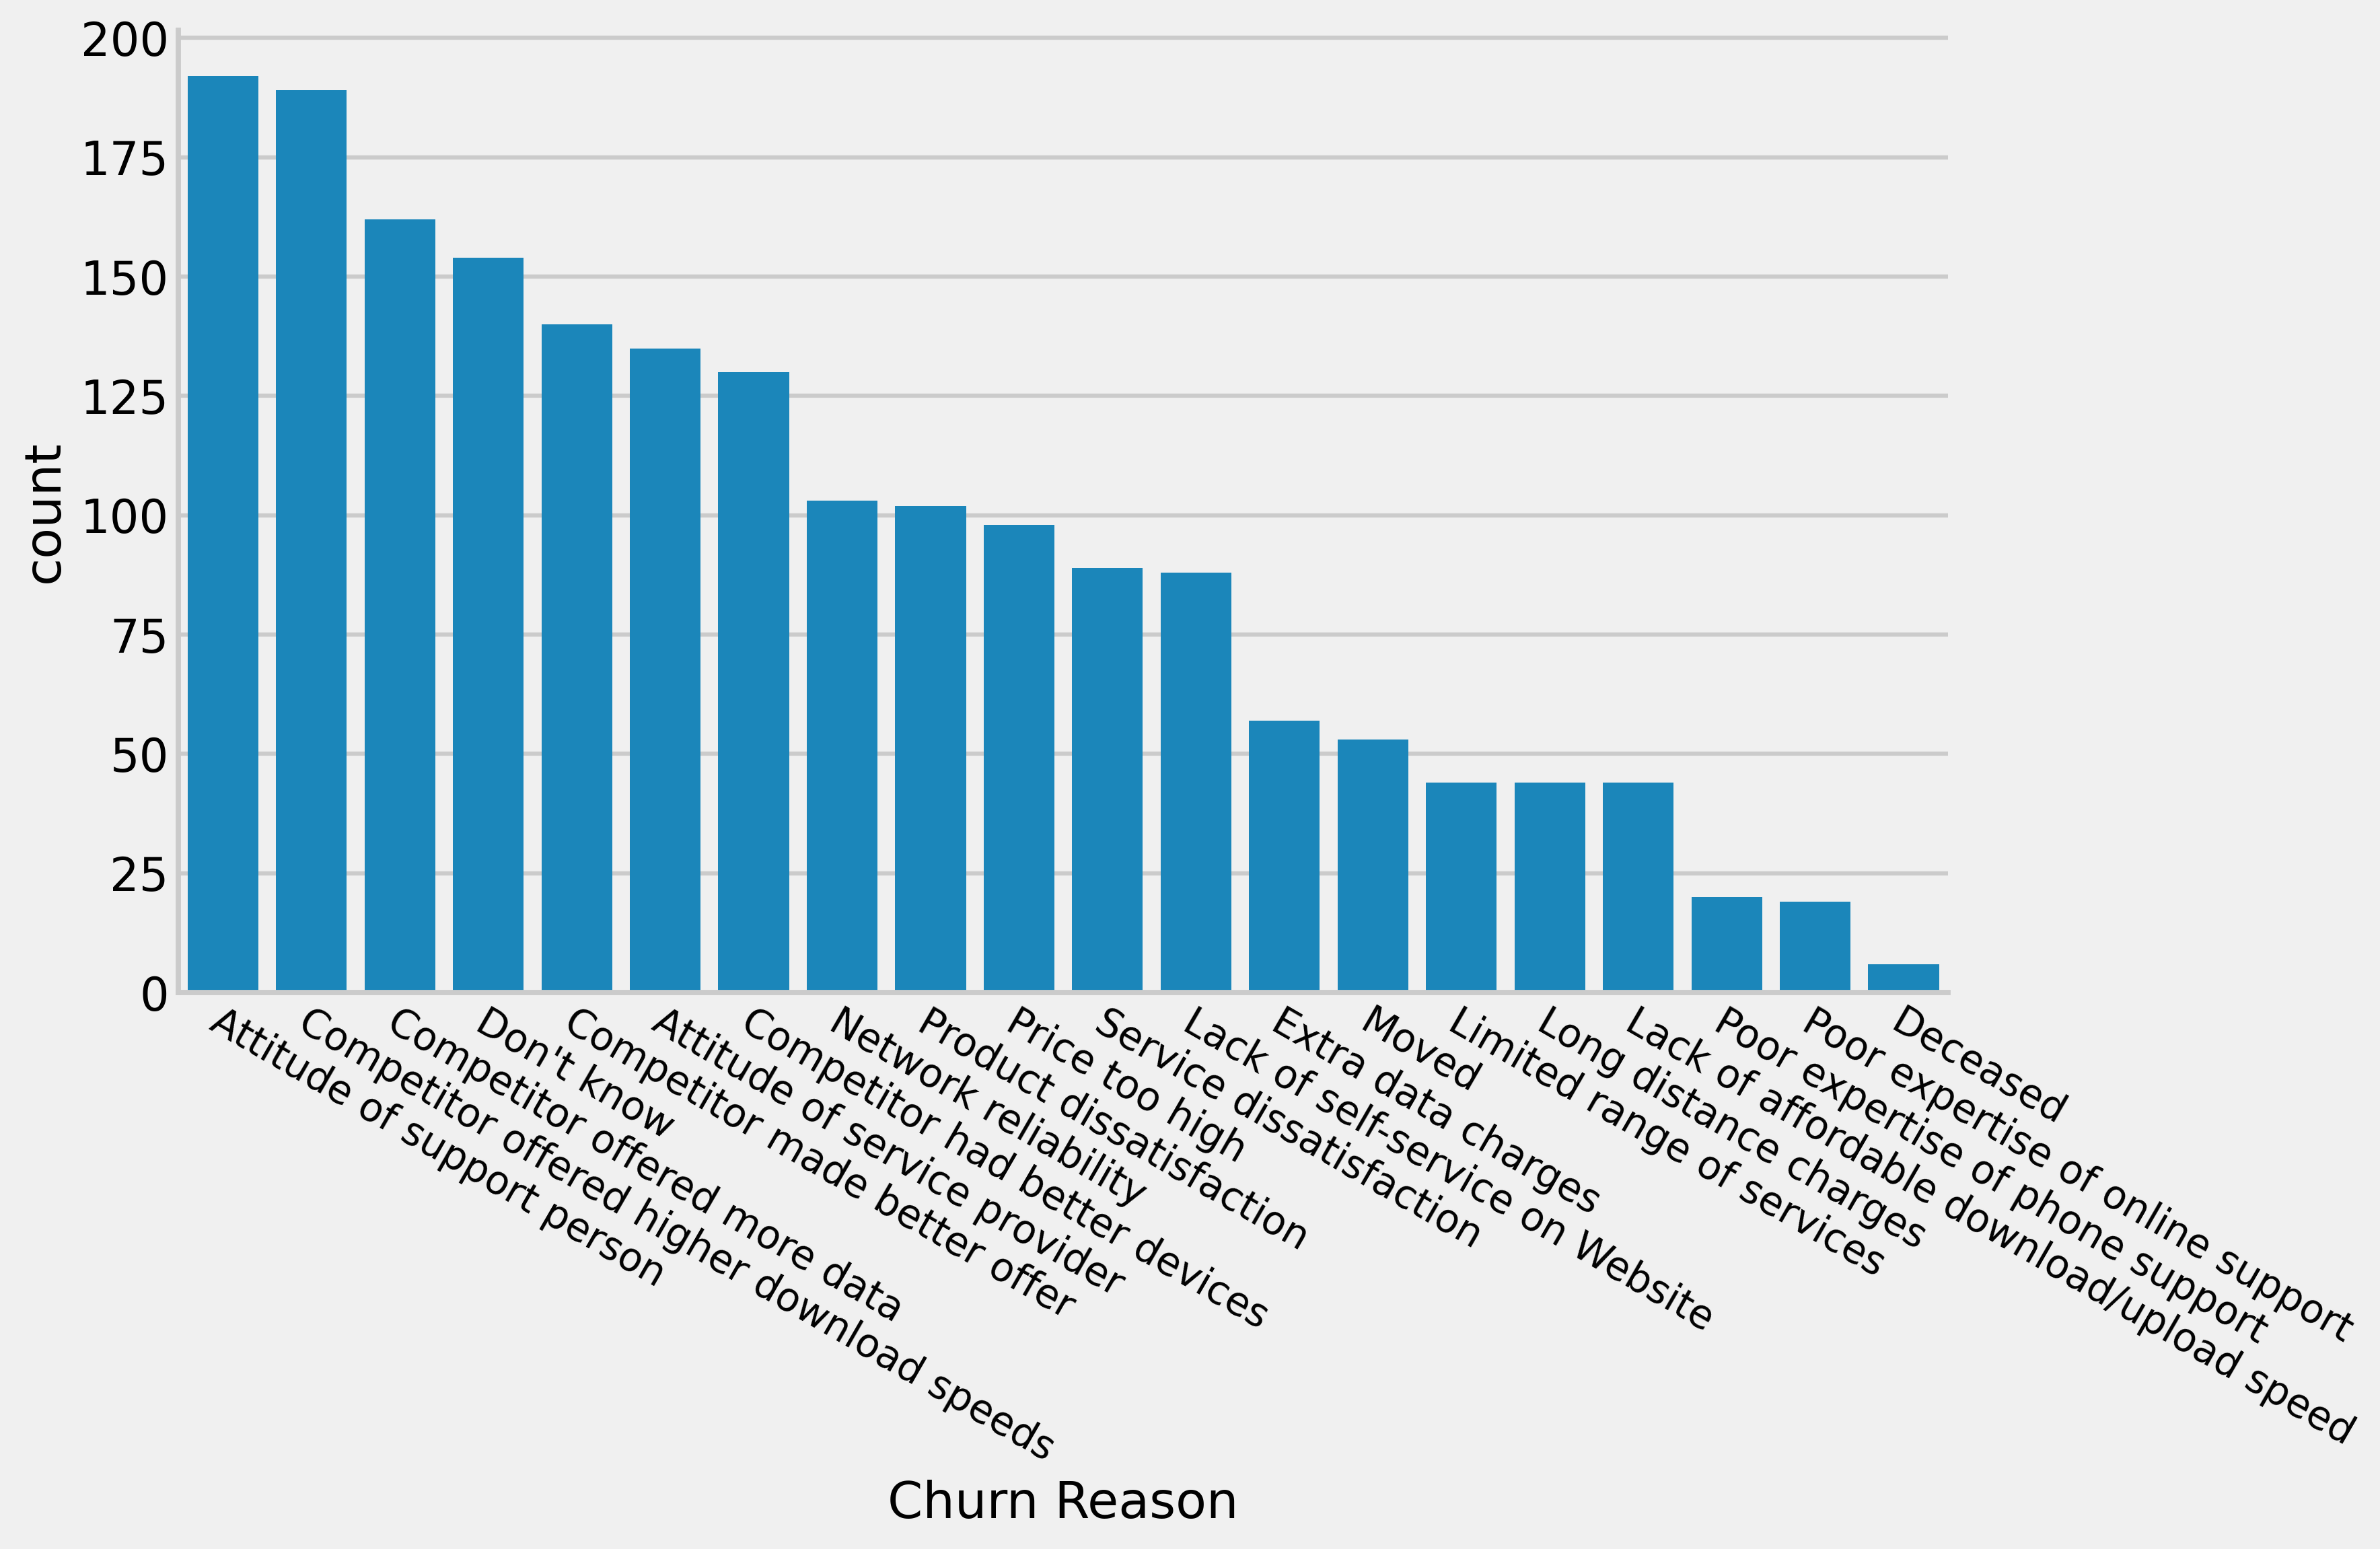

In [4]:
s = df['Churn Reason'].dropna()

sns.countplot(x=s, color=sns.color_palette()[0], 
              order=s.value_counts().index)

fig = plt.gcf()
ax = fig.get_axes()[0]

for label in ax.get_xticklabels():
    label.set_ha('left')
    label.set_rotation(330)
    label.set_fontsize(14)
    label.set_rotation_mode('anchor')


plt.show()



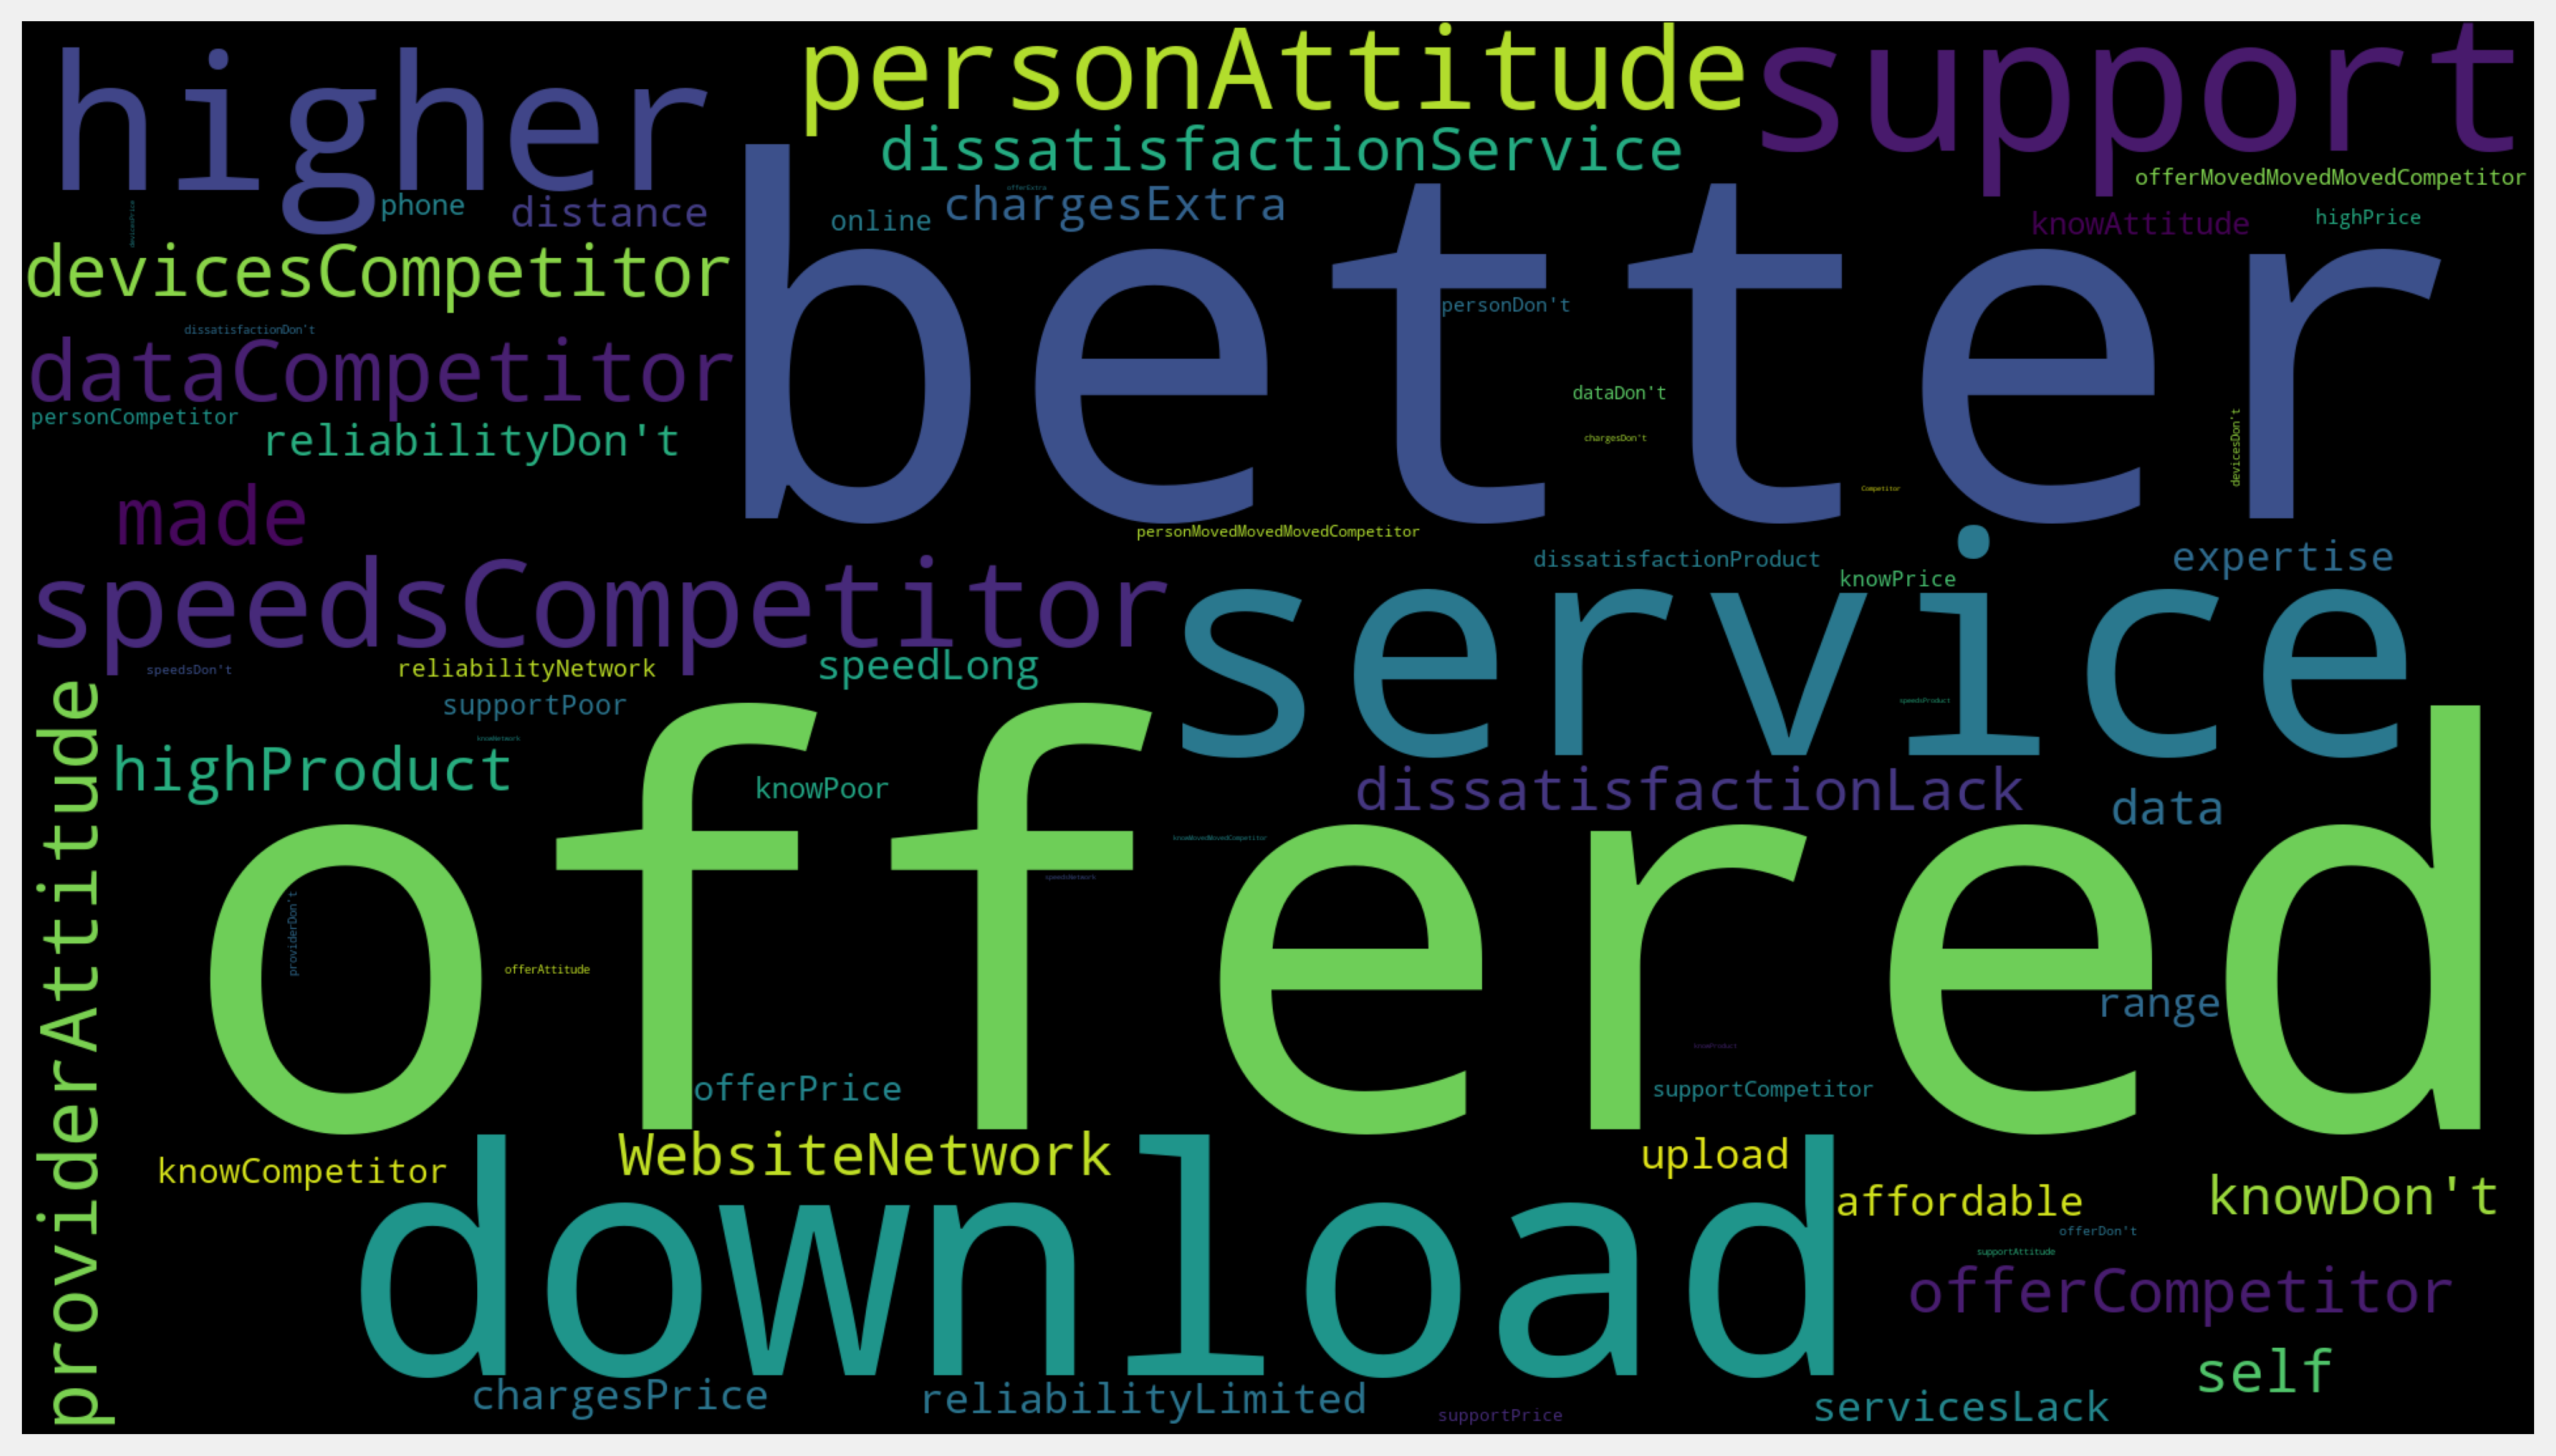

In [5]:
df = df[df['Churn Reason']!='Deceased']
text = df['Churn Reason'].dropna().str.cat()
word_cloud = WordCloud(collocations = False, width=1920, height=1080).generate(text)
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [6]:
def make_binned_averages(data, feature, target, bw, bmin=0, bmax=0):   
    sf = data.copy()

    if bmax == 0:
        bmax = max(sf[feature]) 

    bins = np.arange(bmin, bmax + bw, step=bw)
    n, b = np.histogram(sf[feature], bins=bins)
    m = (b[1:] + b[:-1]) / 2

    sf.loc[:, 'binrange'] = pd.cut(sf[feature], bins=bins)

    g = sf.groupby('binrange')[target].mean()

    ntup = namedtuple("BinnedData", ["r", "means", "feature", "target", "bins"])

    return ntup(m, g, sf[feature], sf[target], bins)

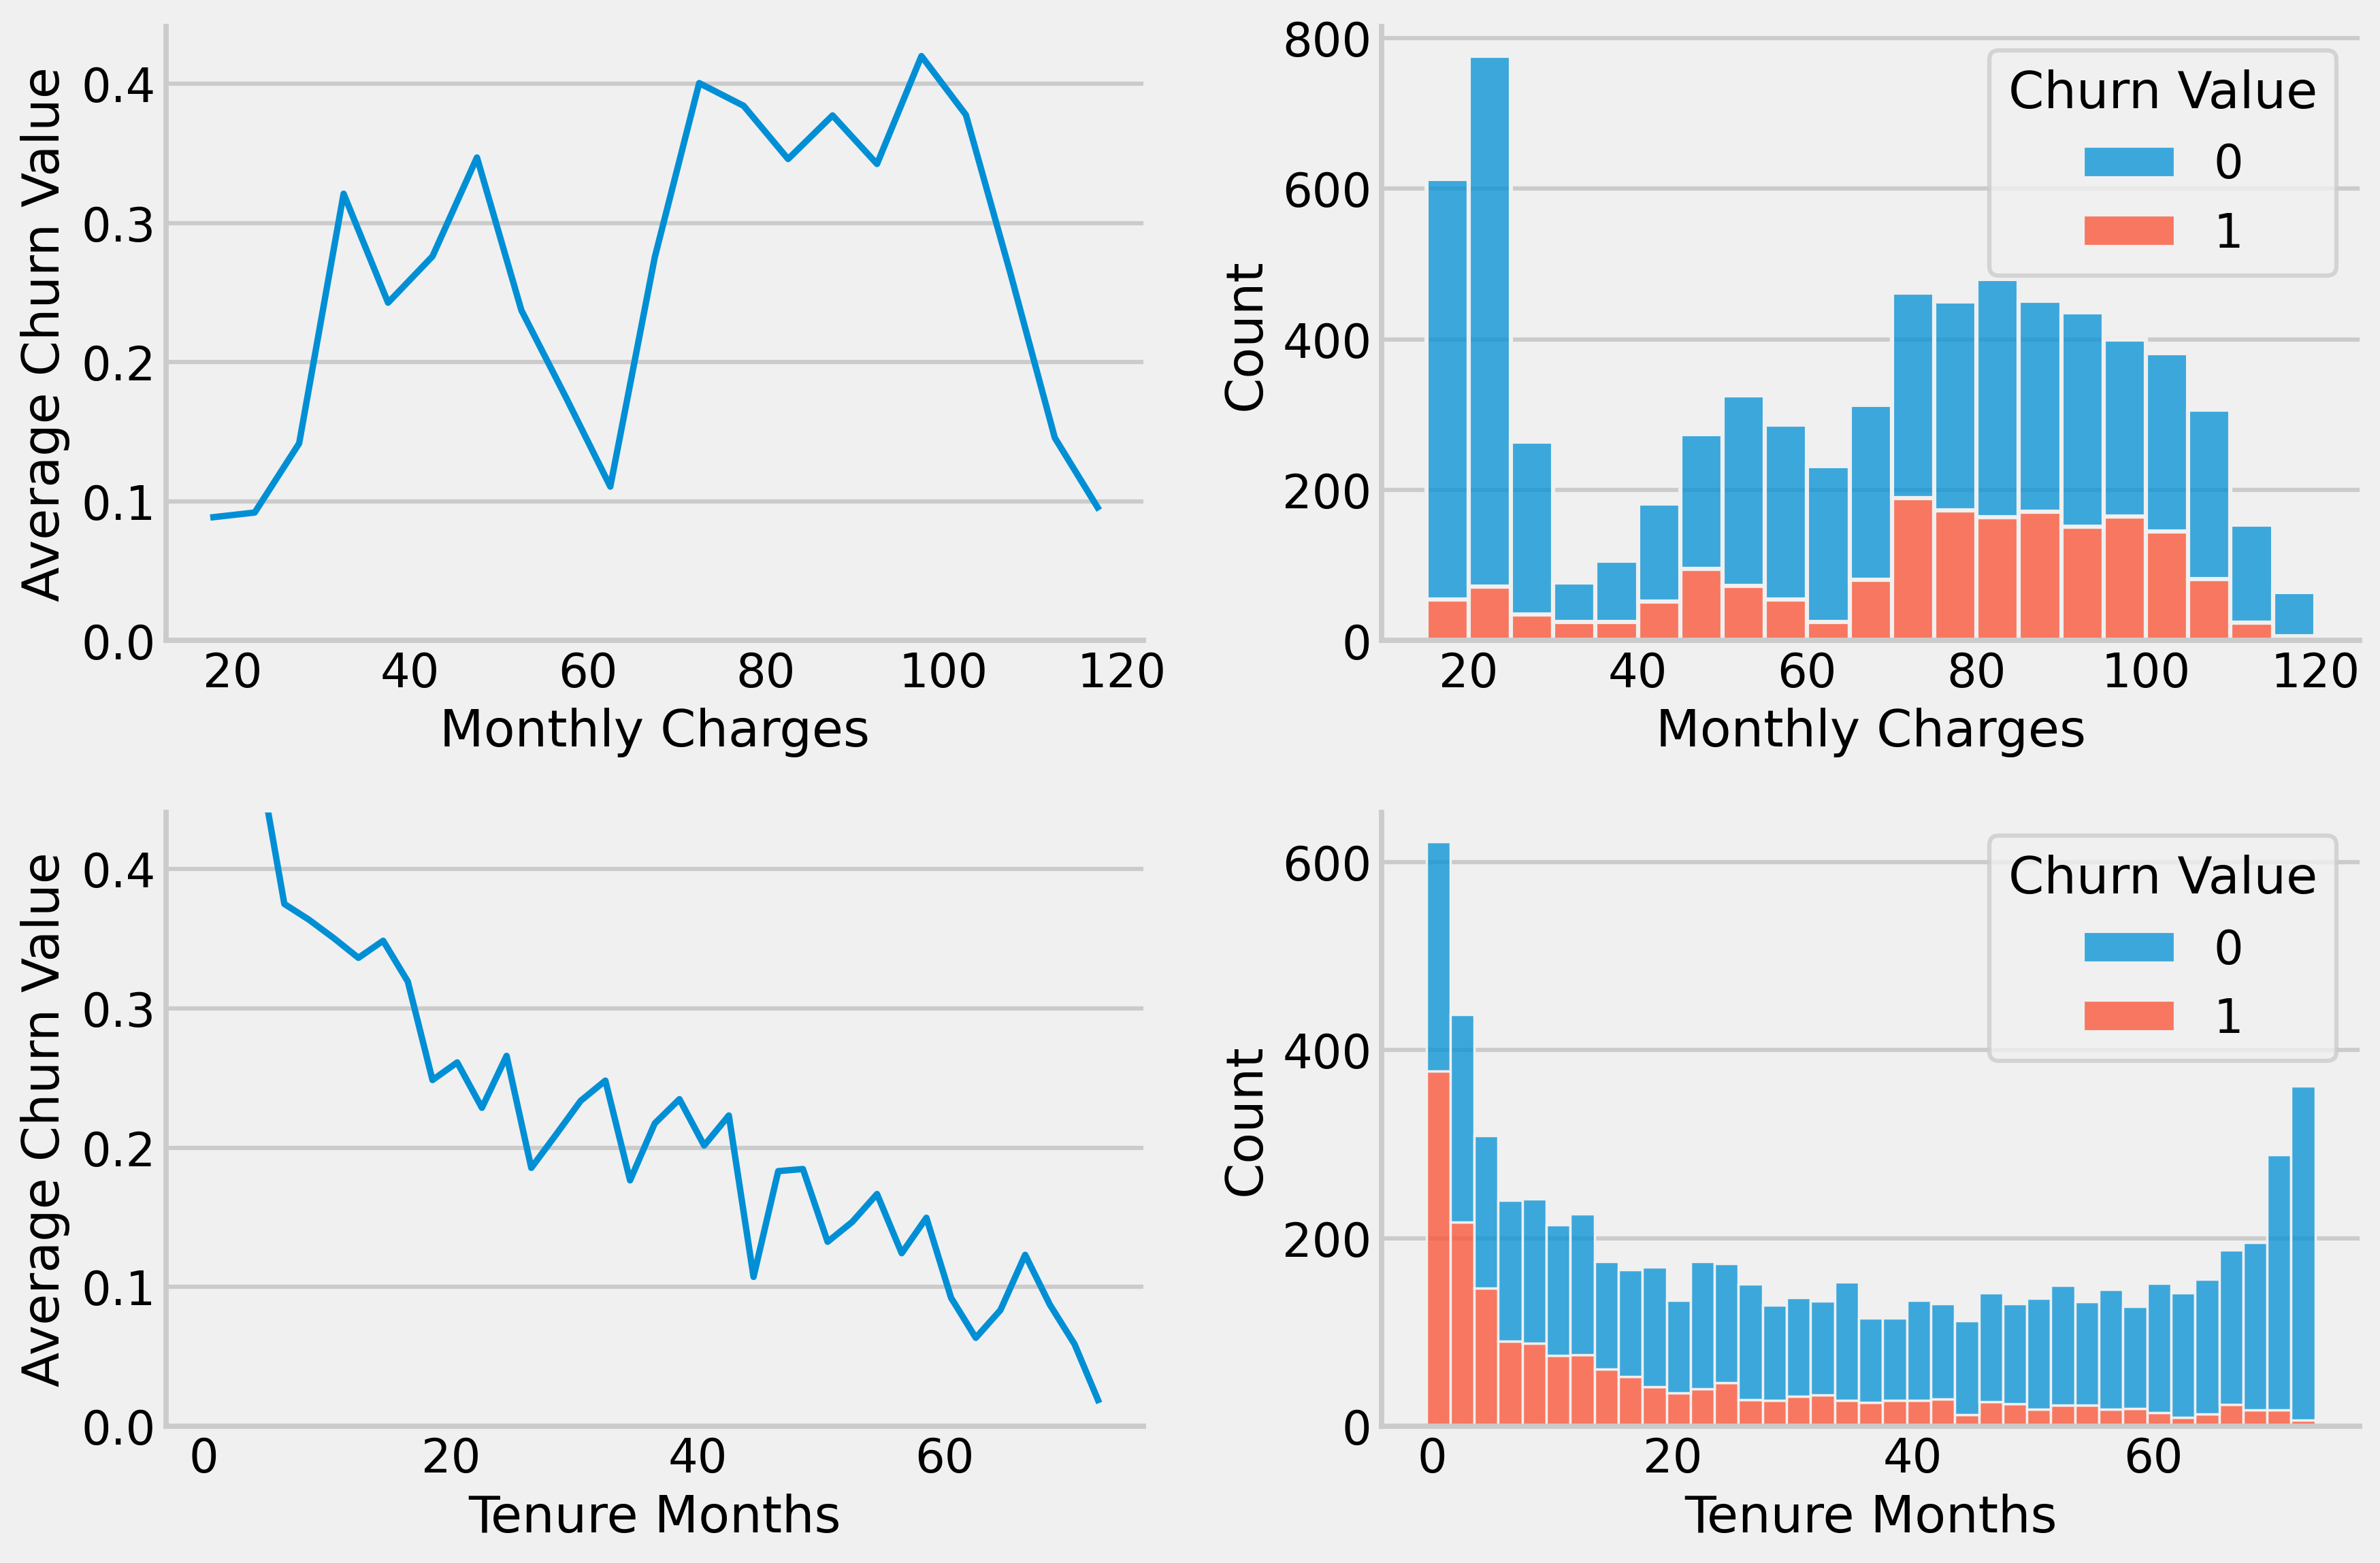

In [7]:
temporal_features = ["Monthly Charges", "Tenure Months", "Total Charges"]
target = 'Churn Value'


df['Total Charges'].replace(' ', 0, inplace=True)
df['Total Charges'] = df['Total Charges'].astype(float)

f0d = make_binned_averages(df, temporal_features[0], target, bw=5, bmin=15, bmax=120)
f1d = make_binned_averages(df, temporal_features[1], target, bw=2, bmin=-0.5)

fig, axes = plt.subplots(2, 2)

# maybe this should be relative to show diffs
sns.lineplot(x=f0d.r, y=f0d.means, ax=axes[0, 0])
axes[0, 0].set_xlabel(temporal_features[0])
axes[0, 0].set_ylabel(f'Average {target}')
axes[0, 0].set_ylim([0, max(f0d.means) * (1.05)])
sns.histplot(x=f0d.feature, hue=f0d.target, bins=f0d.bins, multiple='stack', ax=axes[0, 1])

sns.lineplot(x=f1d.r, y=f1d.means, ax=axes[1, 0])
axes[1, 0].set_xlabel(temporal_features[1])
axes[1, 0].set_ylabel(f'Average {target}')
axes[1, 0].set_ylim([0, max(f0d.means) * (1.05)])
sns.histplot(x=f1d.feature, hue=f1d.target, bins=f1d.bins, multiple='stack', ax=axes[1, 1])
plt.show()

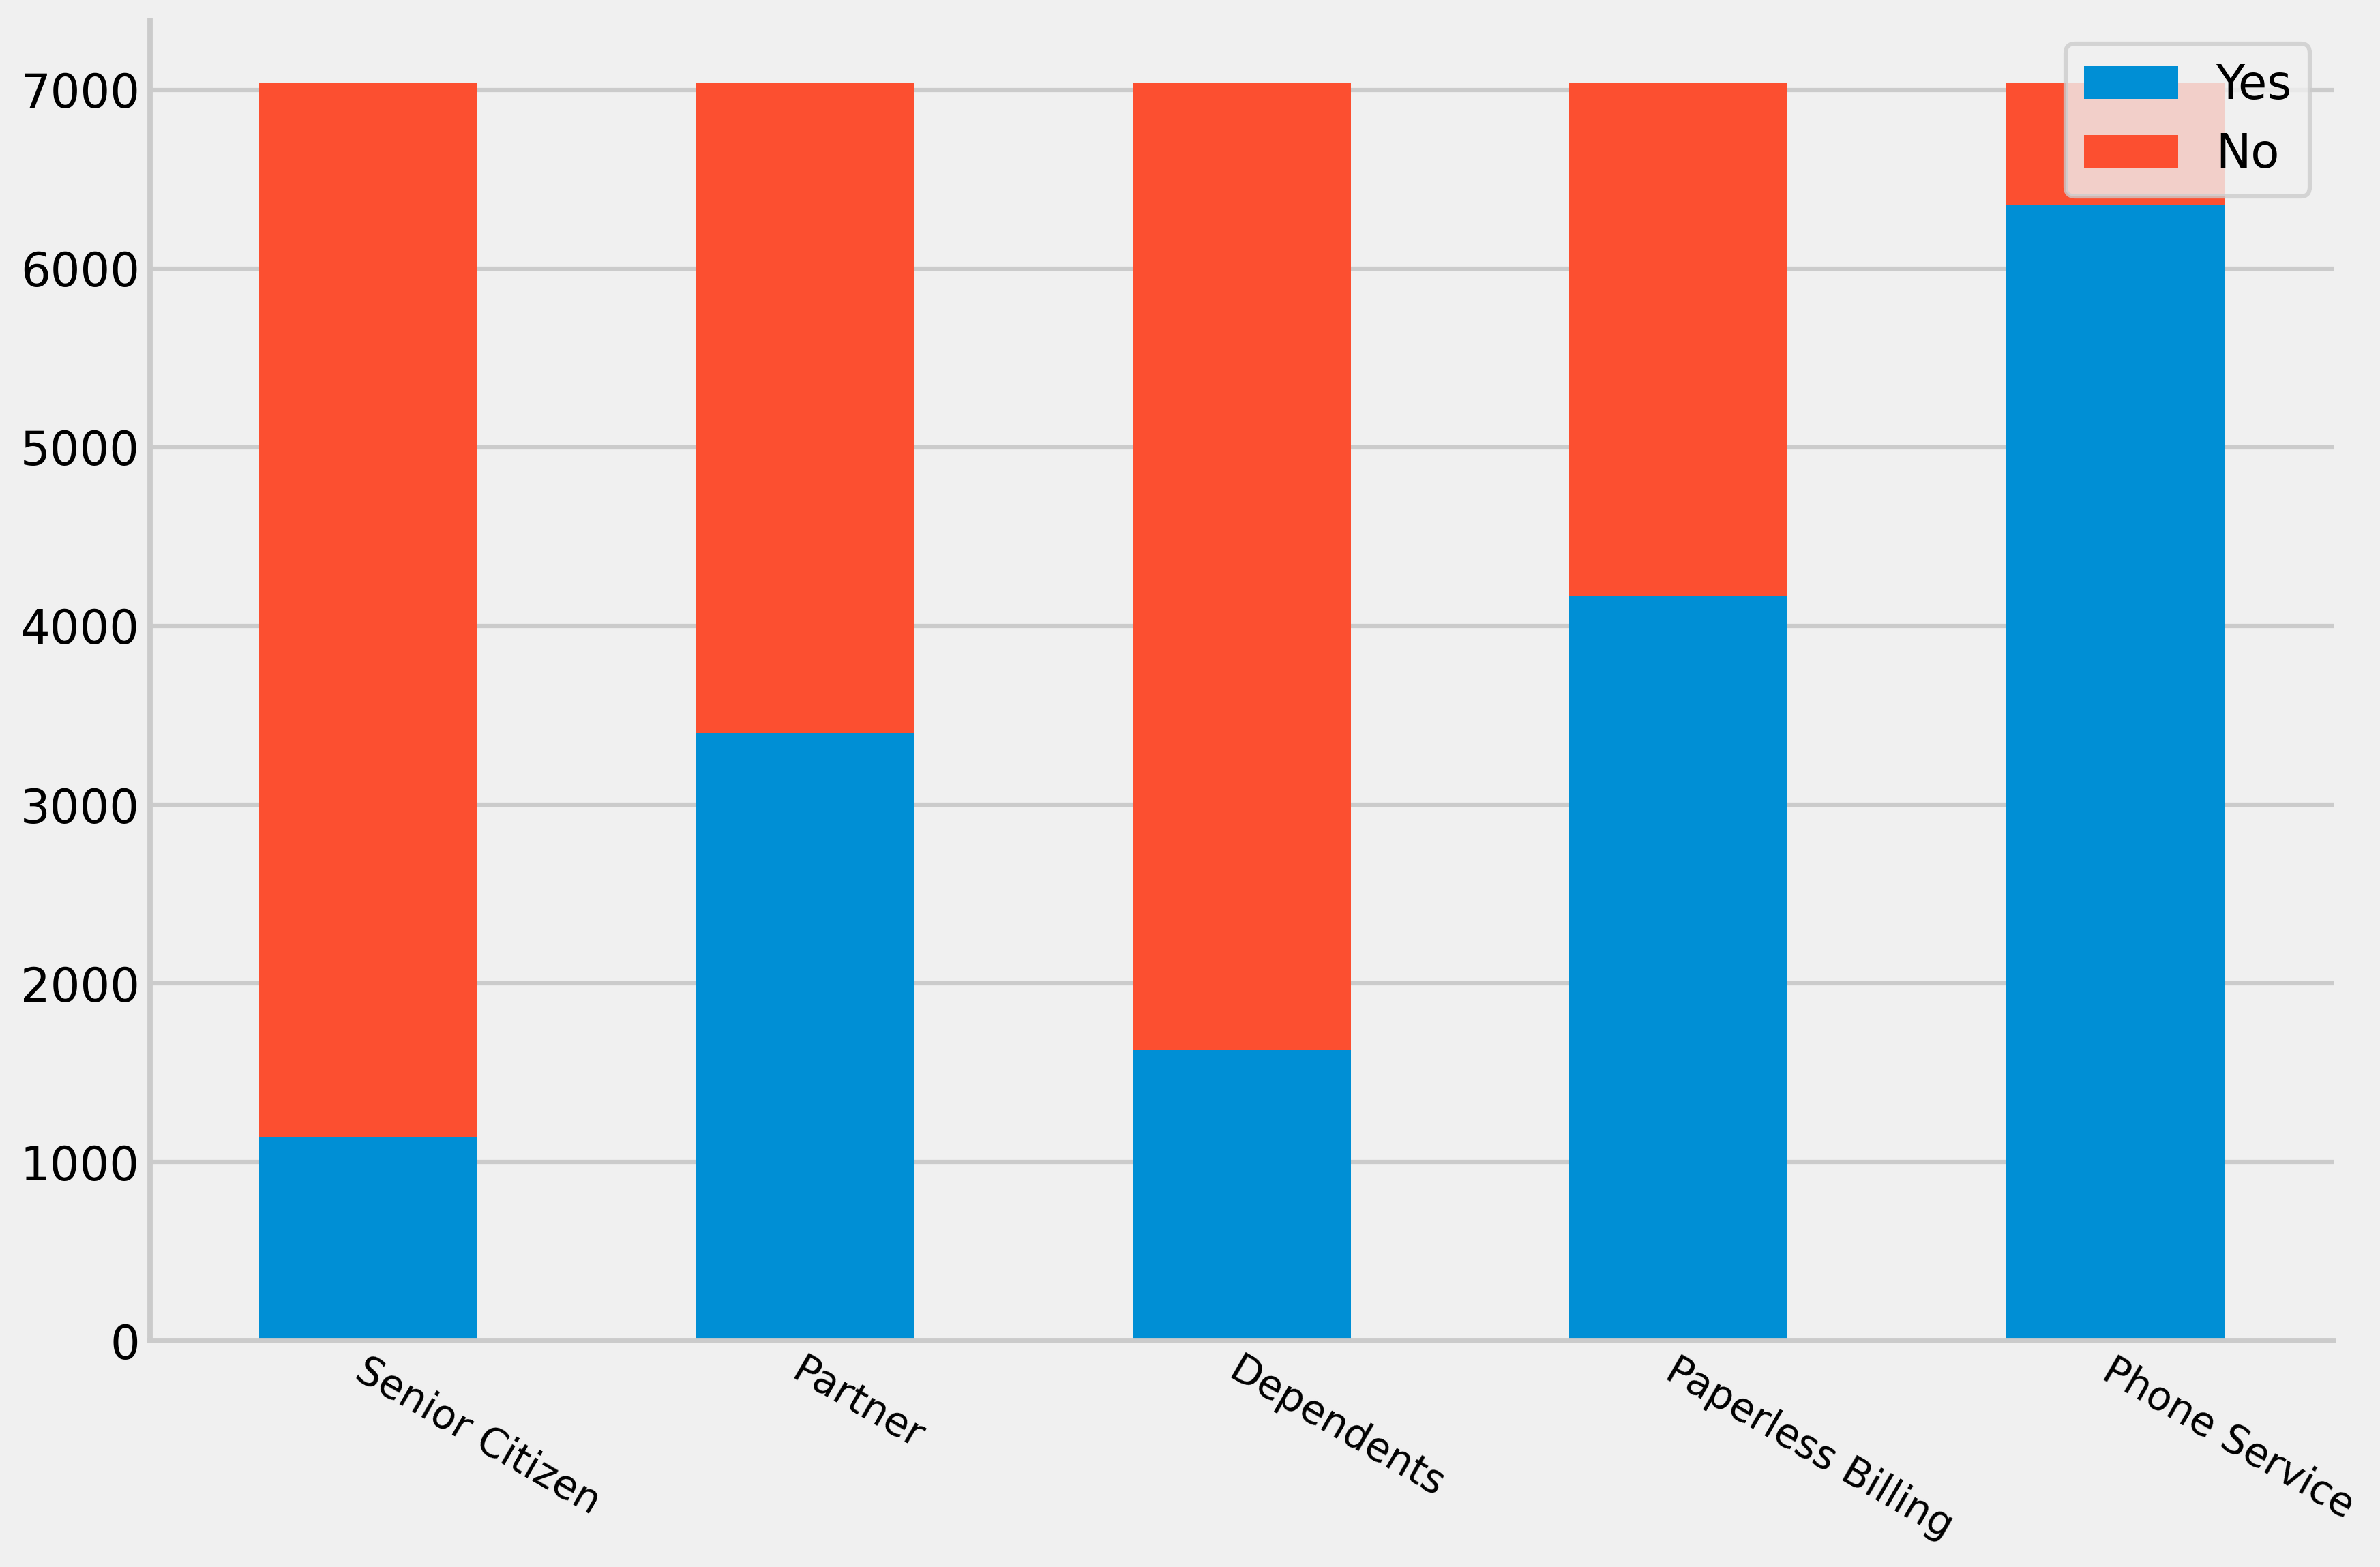

In [8]:
binary_features = ["Senior Citizen", "Partner", "Dependents", "Paperless Billing", "Phone Service"]

online_features = ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',]

target = 'Churn Value'

h = df.loc[:, binary_features].apply(lambda col: col.value_counts()).T.fillna(0)
h[['Yes', 'No']].plot(kind='bar', stacked=True, rot=330)



plt.grid(visible=False, axis='x')
fig = plt.gcf()

ax = fig.get_axes()[0]
for label in ax.get_xticklabels():
    label.set_ha('left')
    label.set_rotation_mode('anchor')
    label.set_fontsize(14)


# hf = df.loc[:, binary_features].apply(lambda col: df.groupby(col)[target].mean()).fillna(0).T
# hf.sort_values(by="Yes", ascending=False, inplace=True)

# ax2 = ax.twinx()
# ax2.grid(False)
# ax2.set_ylabel('Average Churn Value')
# sns.lineplot(x=hf.index, y=hf['Yes'], linestyle='--')
# sns.lineplot(x=hf.index, y=hf['No'], linestyle='--')

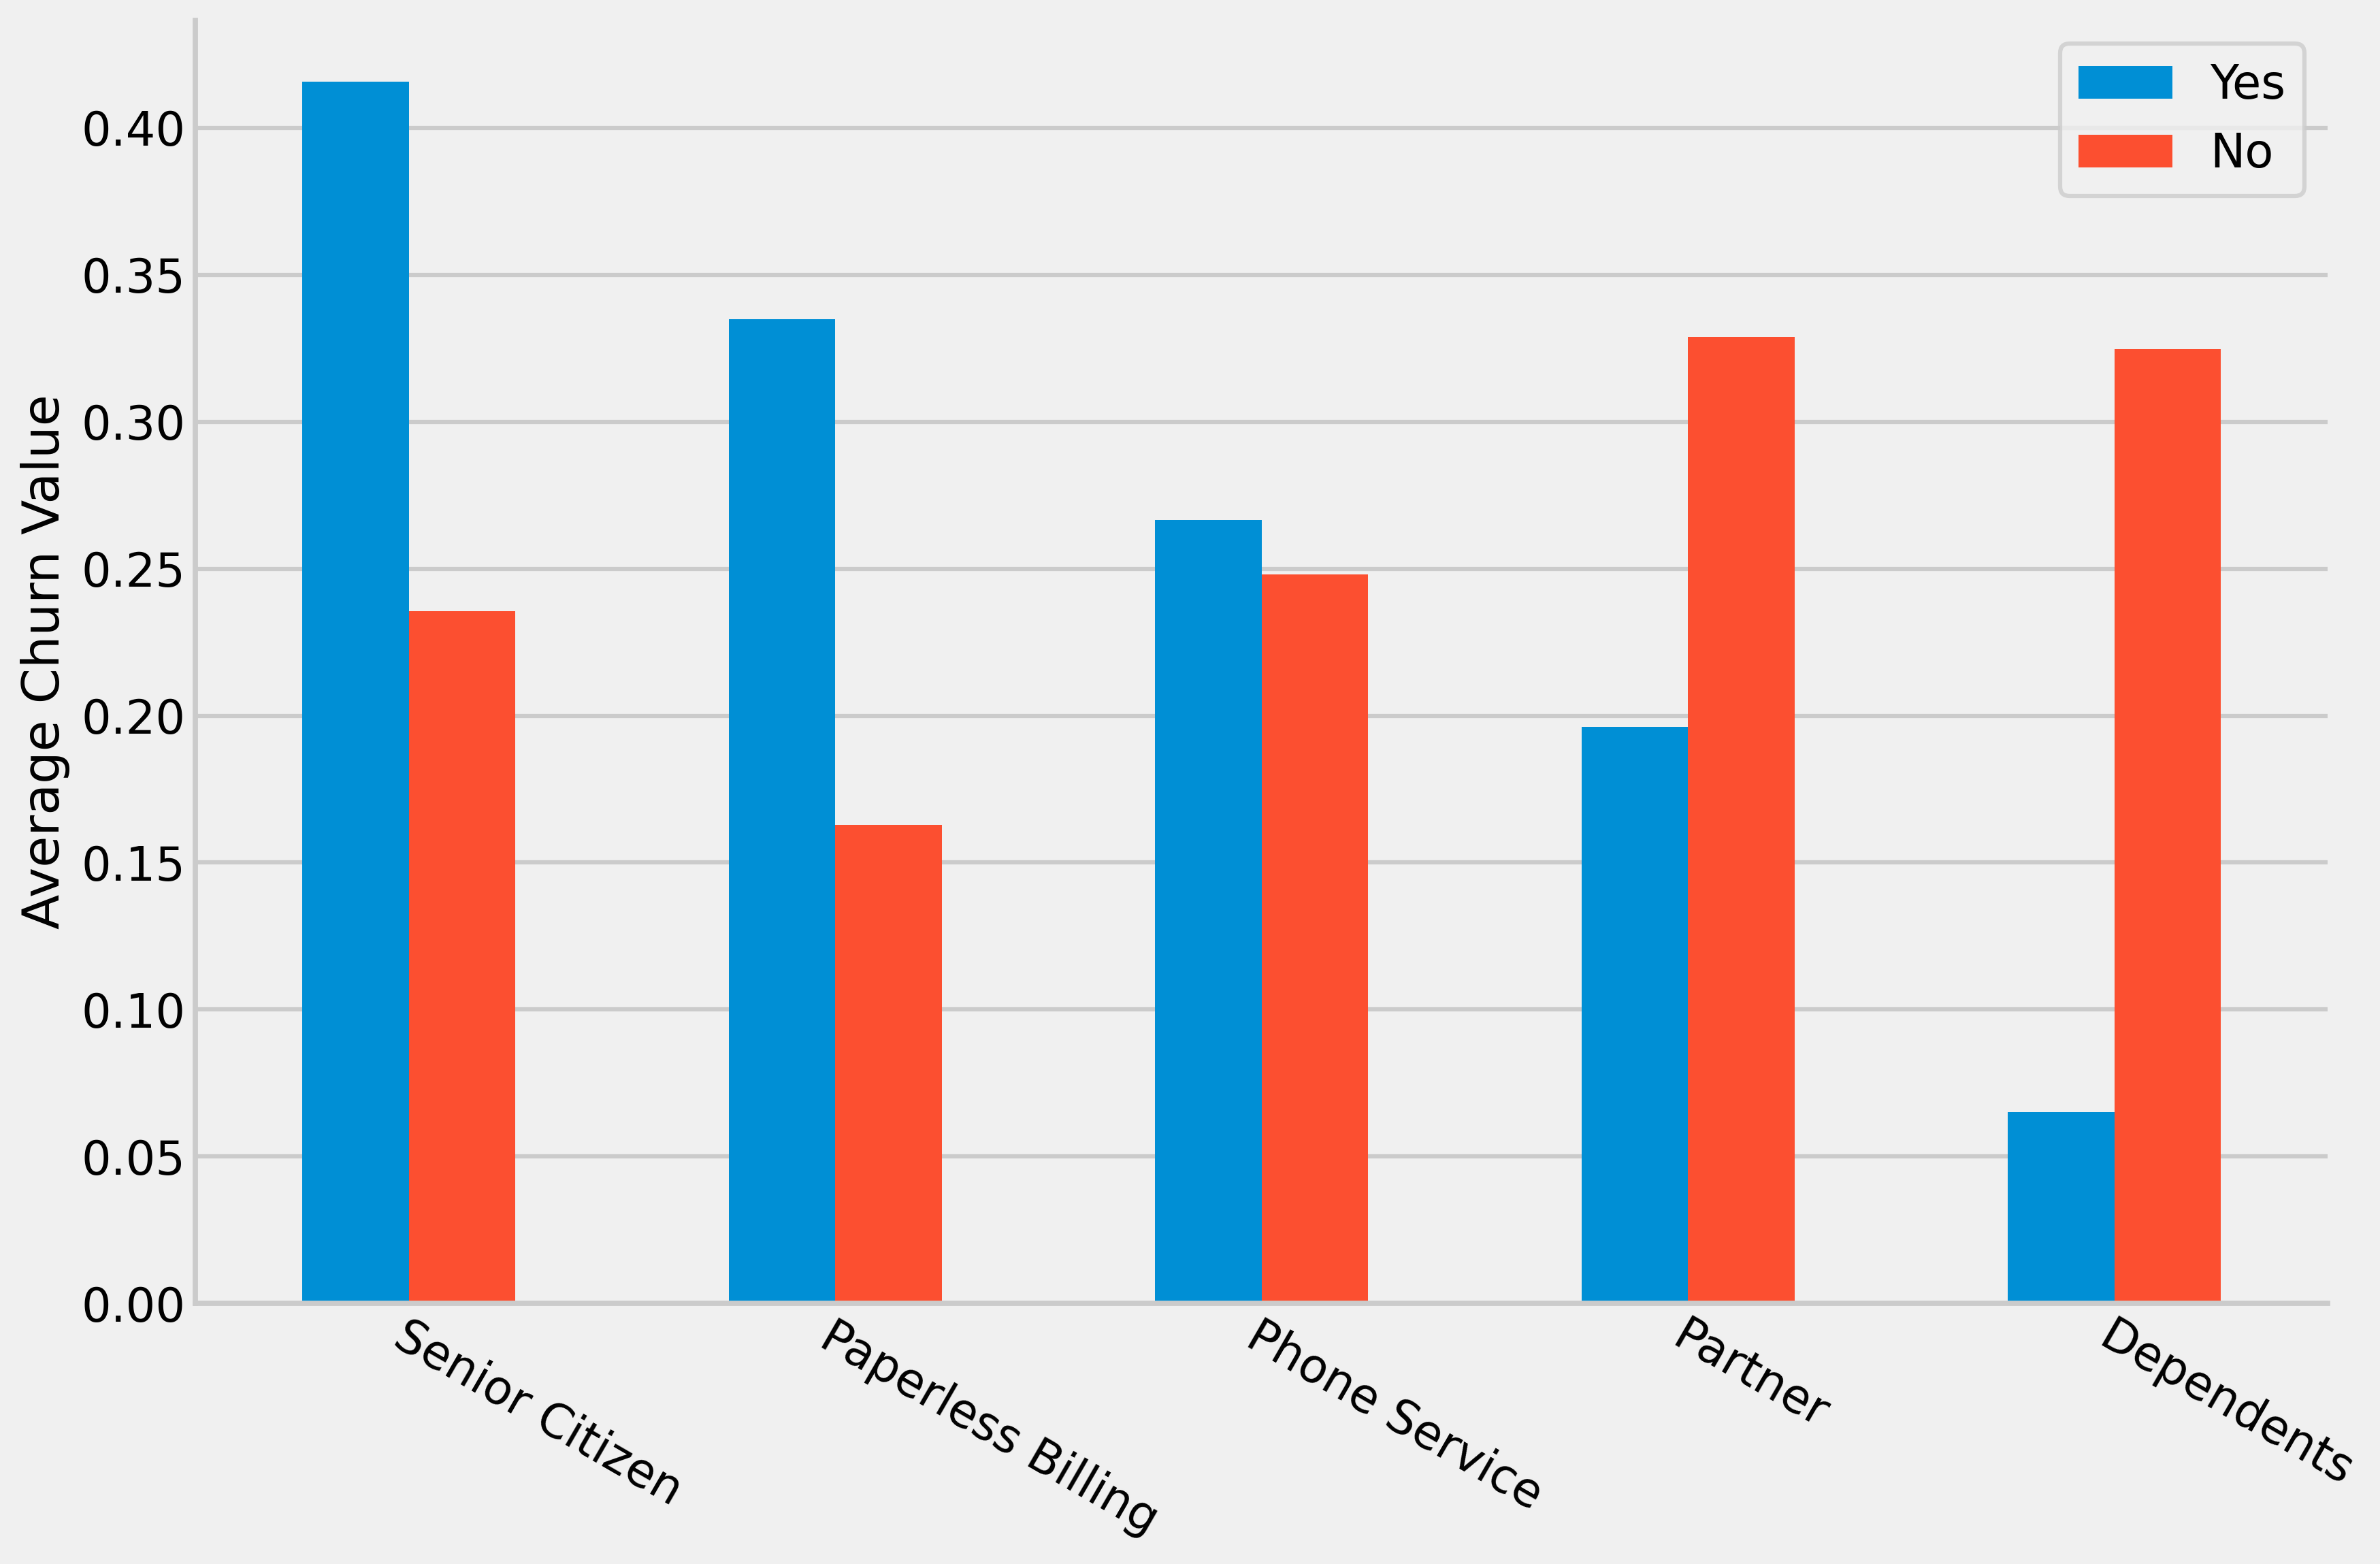

In [9]:
binary_features = ["Senior Citizen", "Partner", "Dependents", "Paperless Billing", "Phone Service"]

online_features = ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',]

target = 'Churn Value'

hf = df.loc[:, binary_features].apply(lambda col: df.groupby(col)[target].mean()).fillna(0).T


hf.sort_values(by="Yes", ascending=False, inplace=True)
hf[['Yes', 'No']].plot(kind='bar', rot=330, ylabel='Average Churn Value')

plt.grid(visible=False, axis='x')
fig = plt.gcf()
ax = fig.get_axes()[0]
for label in ax.get_xticklabels():
    label.set_ha('left')
    label.set_rotation_mode('anchor')

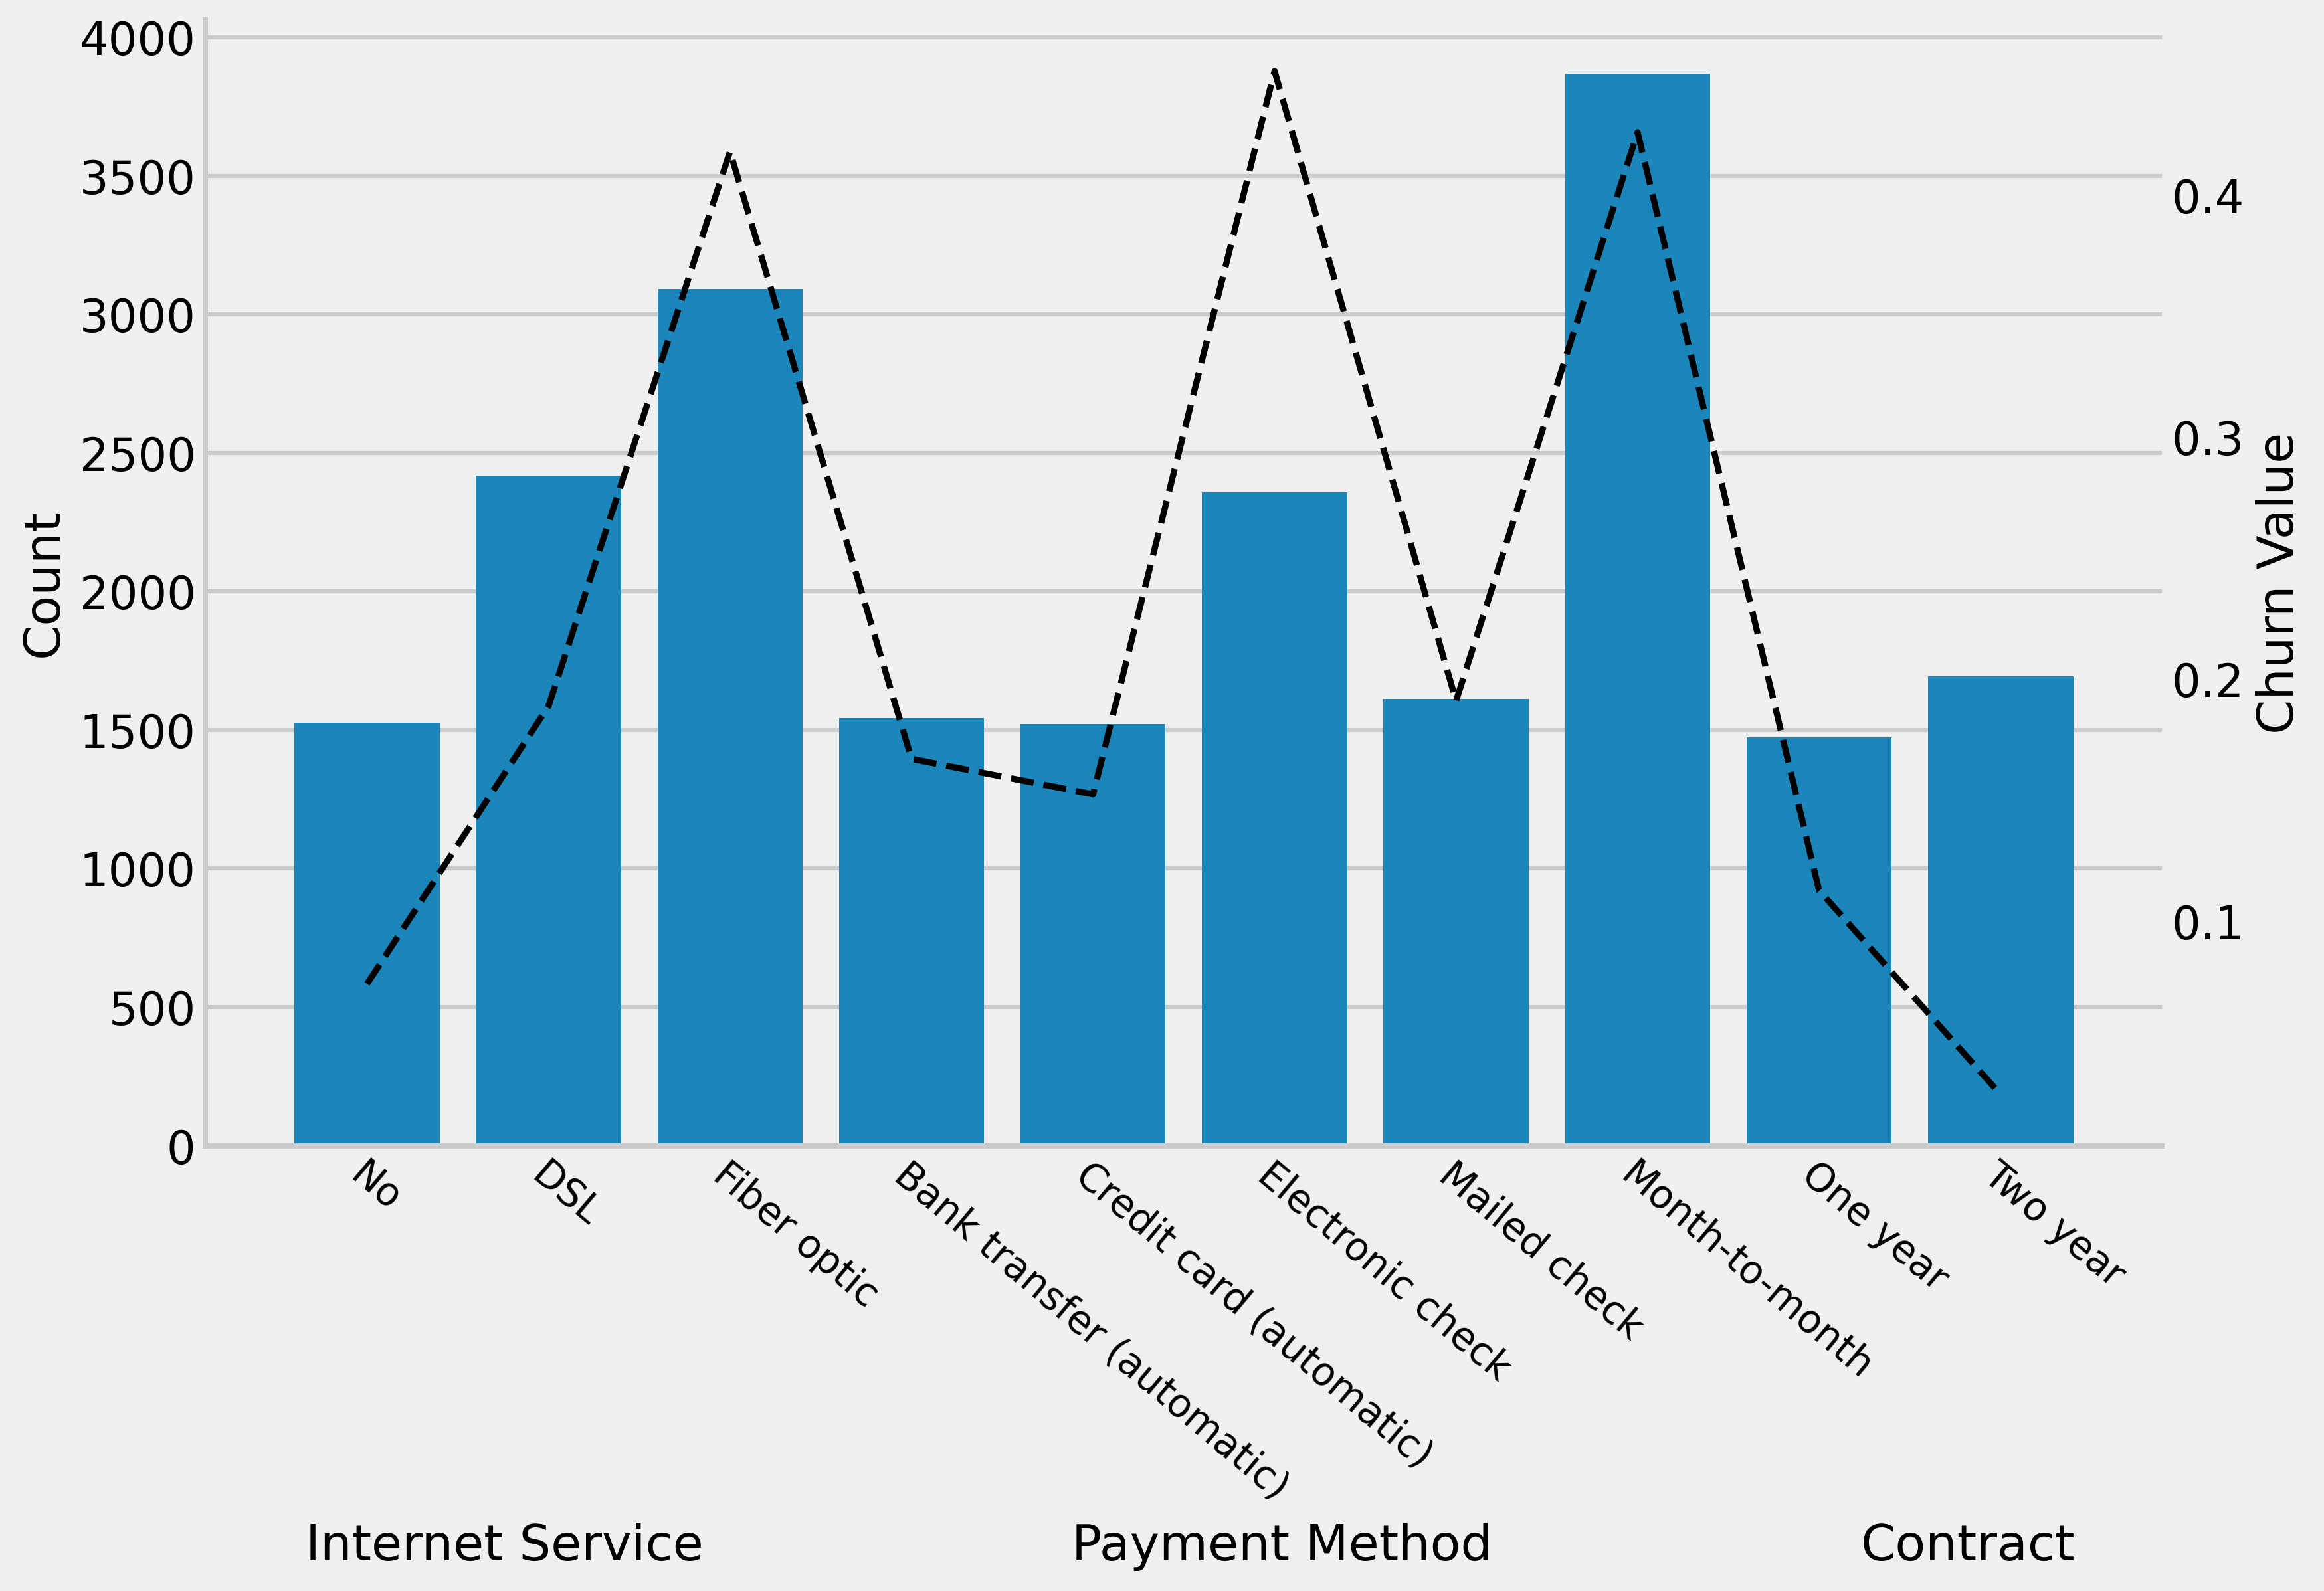

In [10]:
multiopt_features = ['Internet Service', 'Contract', 'Payment Method']

h = df.loc[:, multiopt_features].apply(pd.Series.value_counts).sort_values(by='Internet Service')


counts = h.fillna(method='ffill', axis=1).iloc[:, -1]
counts.name = 'Count'

sns.barplot(x=counts.index, y=counts, color=sns.color_palette()[0])

# steps to get x coords for text
# step_size = 0.086
# xval = 0.116

label_xcoords = [0.225, 0.837, 0.550]

fig = plt.gcf()

for i in range(len(multiopt_features)):
    fig.text(label_xcoords[i], 0, multiopt_features[i], ha='center')

ax = fig.get_axes()[0]
for label in ax.get_xticklabels():
    label.set_ha('left')
    label.set_rotation(320)
    label.set_fontsize(14)
    label.set_rotation_mode('anchor')

lst_df = []
for feature in multiopt_features:
    g = df.loc[:,[feature, 'Churn Value']].groupby(feature).mean()
    g['feature'] = [feature] * len(g)
    lst_df.append(g)

cf = pd.concat(lst_df)

cf = cf.reindex(index=counts.index)

ax2 = ax.twinx()
ax2.grid(False)
sns.lineplot(x=cf.index, y=cf['Churn Value'], color='black', linestyle='--', ax=ax2)
plt.show()



In [12]:
# multiopt_features = ['Internet Service', 'Contract', 'Payment Method']


# lst_df = []
# for feature in multiopt_features:
#     g = df.loc[:,[feature, 'Churn Value']].groupby(feature).mean()
#     g['feature'] = [feature] * len(g)
#     lst_df.append(g)

# cf = pd.concat(lst_df)

# fig, axes = plt.subplots(3, 1, sharex=True, 
#                          gridspec_kw={'height_ratios': [1, 1, 1.35]})
# axes[0].spines[['top', 'bottom', 'right', 'left']].set_visible(False)
# axes[1].spines[['top', 'bottom', 'right', 'left']].set_visible(False)
# axes[2].spines[['top', 'bottom', 'right', 'left']].set_visible(False)
# axes[2].set_xlabel('Average Churn Value')

# for k, v in enumerate(multiopt_features):
#     cf[cf['feature']==v].plot(kind='barh', ax=axes[k], width=0.4, legend=False, ylabel=v)

# plt.show()



In [13]:
# target = 'Churn Value'
# cols_to_drop = ['Churn Score', 'Churn Reason', 'Churn Label', 'Latitude', 'Longitude', 'Zip Code', 'Lat Long', 'CustomerID', 'Count', 'Country', 'State', 'Gender', 'City']

# nf = df.drop(columns=cols_to_drop)

# # scaler = MinMaxScaler()

# # pnf['Tenure Months'] = scaler.fit_transform(pnf['Tenure Months'].values.reshape(-1, 1))
# # pnf['Monthly Charges'] = scaler.fit_transform(pnf['Monthly Charges'].values.reshape(-1, 1))
# # pnf['Total Charges'] = scaler.fit_transform(pnf['Total Charges'].values.reshape(-1, 1))


# binary_features = [c for c in nf.columns if len(nf[c].unique()) == 2 and nf[c].dtype==object]


# multiopt_features = [c for c in nf.columns if nf[c].dtype==object and c not in binary_features]

# nf[binary_features] = nf[binary_features].apply(lambda g: g.map({"Yes": 1, "No": 0}))

# nf = pd.get_dummies(nf, columns=multiopt_features).dropna()

# x = nf.drop(columns=[target])
# y = nf[target]

# pca = PCA(n_components=3)

# x_pca = pca.fit_transform(x)

# pca_labels = [f"PC {i+1} ({var:.1f}%" for i, var in enumerate(pca.explained_variance_ratio_ * 100)]

# pca_df = pd.DataFrame({pca_labels[i]:x_pca[:, i] for i in range(3)})

# pca_df.loc[:, 'color'] = df['CLTV']

# sns.pairplot(data=pca_df, vars=pca_labels, diag_kws={"linewidth": 0, 'fill': False})
# plt.show()

In [14]:
# kmeans = KMeans(n_clusters=5, n_init=10)
# xc = kmeans.fit_predict(x)

# label_cmap = {0 : 'r', 1 : 'g', 2 : 'b', 3 : 'c', 4 : 'm'}
# label_color = [label_cmap[i] for i in xc]


# sns.scatterplot(x=x_pca[:, 0], y=x_pca[:, 1], hue=label_color, alpha=0.3)
# plt.show()